In [5]:
import sys
sys.path.append("../")  # import path starts with src/

from sklearn.decomposition import PCA
from preprocessing.create_train_test_dicts import build_original_splits
from preprocessing.knn_preprocess import dict_to_xy
from sklearn.neighbors import KNeighborsClassifier

ds = build_original_splits()
train_split = ds['train_numeric']
test_split = ds['test_numeric']

X_train, y_train = dict_to_xy(train_split)
X_test, y_test = dict_to_xy(test_split)

pca_final = PCA(n_components=50, whiten=True, random_state=42) #found in param search pca_dim=50
pca_final.fit(X_train)

X_train_pca = pca_final.transform(X_train)
X_test_pca  = pca_final.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=8, weights="distance") #found in  param search k = 8
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)


In [6]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("======== FINAL TEST METRICS ========")
print(f"Accuracy       : {acc:.4f}")
print(f"F1 Macro       : {f1_macro:.4f}")
print(f"F1 Weighted    : {f1_weighted:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



======== FINAL TEST METRICS ========
Accuracy       : 0.4337
F1 Macro       : 0.4310
F1 Weighted    : 0.4286

Classification Report:

              precision    recall  f1-score   support

       angry       0.44      0.28      0.34       958
     disgust       0.46      0.43      0.45       111
        fear       0.42      0.31      0.36      1024
       happy       0.47      0.57      0.52      1774
     neutral       0.32      0.49      0.39      1233
         sad       0.38      0.28      0.32      1247
    surprise       0.67      0.62      0.64       831

    accuracy                           0.43      7178
   macro avg       0.45      0.43      0.43      7178
weighted avg       0.44      0.43      0.43      7178



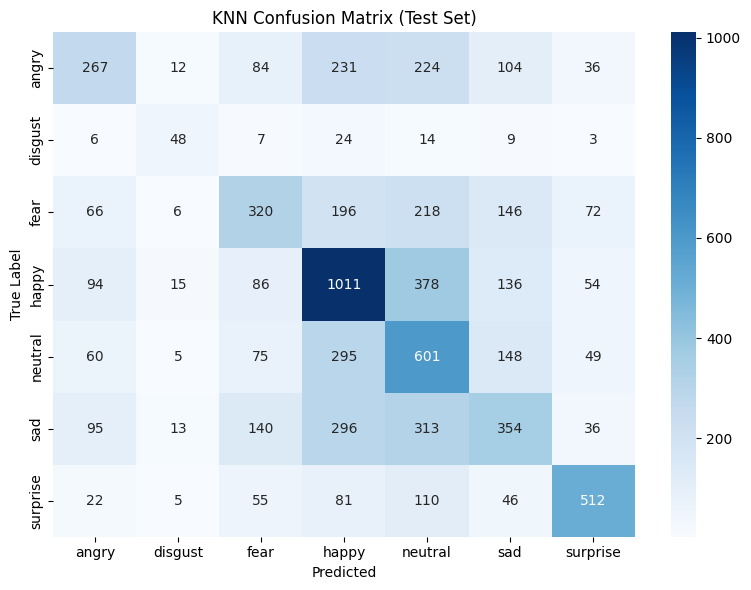

In [7]:
# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
classes = sorted(list(set(y_test)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

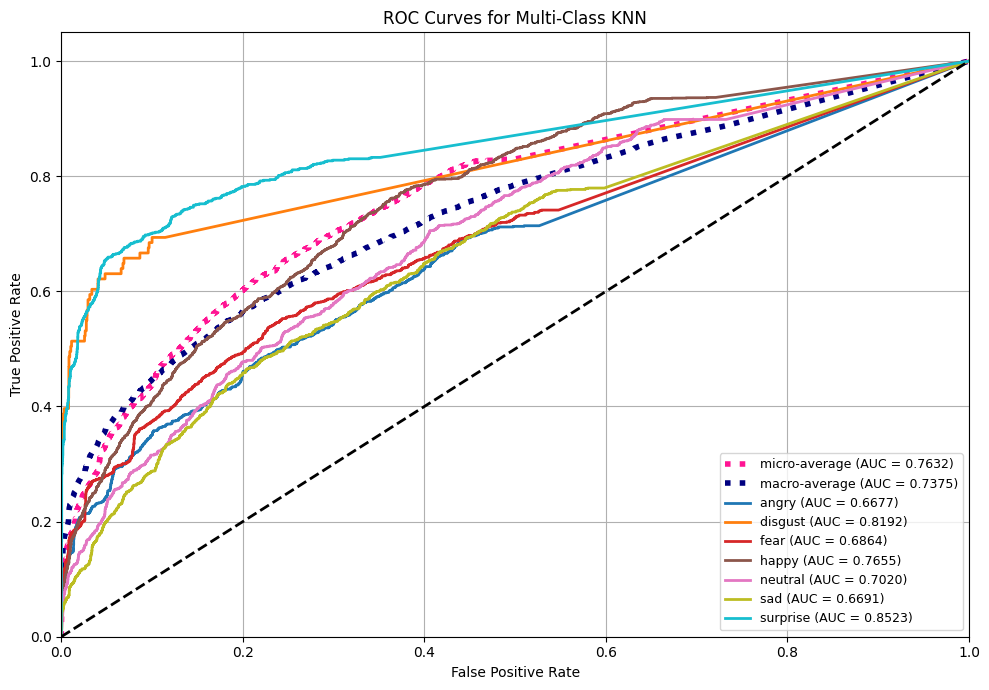

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Binarize labels (one-vs-rest)
# -----------------------------
classes = sorted(list(set(y_test)))
n_classes = len(classes)

y_test_bin = label_binarize(y_test, classes=classes)
y_pred_proba = knn.predict_proba(X_test_pca)  # (N, num_classes)

# -----------------------------
# 2. Compute ROC curve & AUC for each class
# -----------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# -----------------------------
# 3. Compute micro-averaged ROC
# -----------------------------
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_bin.ravel(), y_pred_proba.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# -----------------------------
# 4. Compute macro-averaged ROC
# -----------------------------
# Combine all FPR values
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Average the TPR for each FPR
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# -----------------------------
# 5. Plotting
# -----------------------------
plt.figure(figsize=(10, 7))

# Plot macro & micro curves
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.4f})",
    color="deeppink", linestyle=":", linewidth=4
)
plt.plot(
    fpr["macro"], tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.4f})",
    color="navy", linestyle=":", linewidth=4
)

# Plot one curve per class
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i], tpr[i],
        color=color,
        lw=2,
        label=f"{classes[i]} (AUC = {roc_auc[i]:.4f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class KNN")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


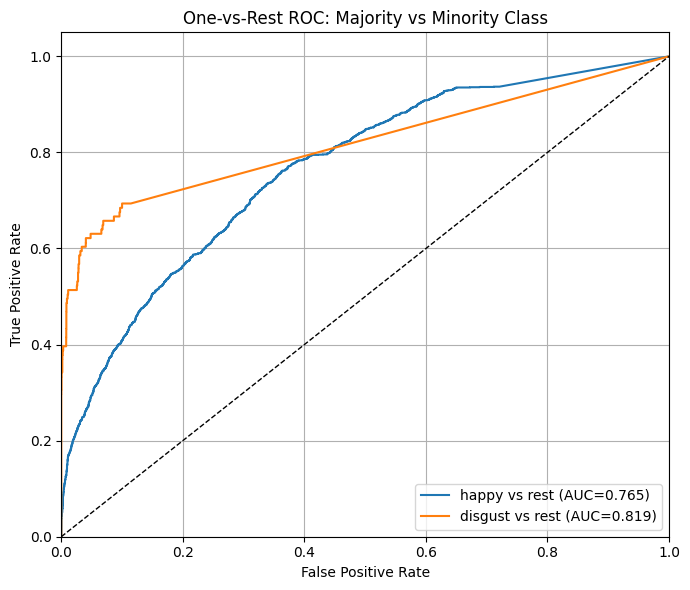

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure classes are consistent with y_pred_proba ordering
classes = sorted(list(set(y_test)))  # if not already defined
class_to_idx = {c: i for i, c in enumerate(classes)}

major_class = "happy"
minor_class = "disgust"

if major_class not in class_to_idx or minor_class not in class_to_idx:
    raise ValueError(f"Check class names: {major_class}, {minor_class} not found in {classes}")

major_idx = class_to_idx[major_class]
minor_idx = class_to_idx[minor_class]

# ------------------------------
# 1. Build binary labels: class vs rest
# ------------------------------
y_true_major = np.array([1 if y == major_class else 0 for y in y_test])
y_true_minor = np.array([1 if y == minor_class else 0 for y in y_test])

# Corresponding predicted probabilities (for that class)
y_score_major = y_pred_proba[:, major_idx]
y_score_minor = y_pred_proba[:, minor_idx]

# ------------------------------
# 2. Compute ROC curves and AUC
# ------------------------------
fpr_major, tpr_major, _ = roc_curve(y_true_major, y_score_major)
auc_major = auc(fpr_major, tpr_major)

fpr_minor, tpr_minor, _ = roc_curve(y_true_minor, y_score_minor)
auc_minor = auc(fpr_minor, tpr_minor)

# ------------------------------
# 3. Plot together
# ------------------------------
plt.figure(figsize=(7, 6))

plt.plot(fpr_major, tpr_major, label=f"{major_class} vs rest (AUC={auc_major:.3f})")
plt.plot(fpr_minor, tpr_minor, label=f"{minor_class} vs rest (AUC={auc_minor:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC: Majority vs Minority Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


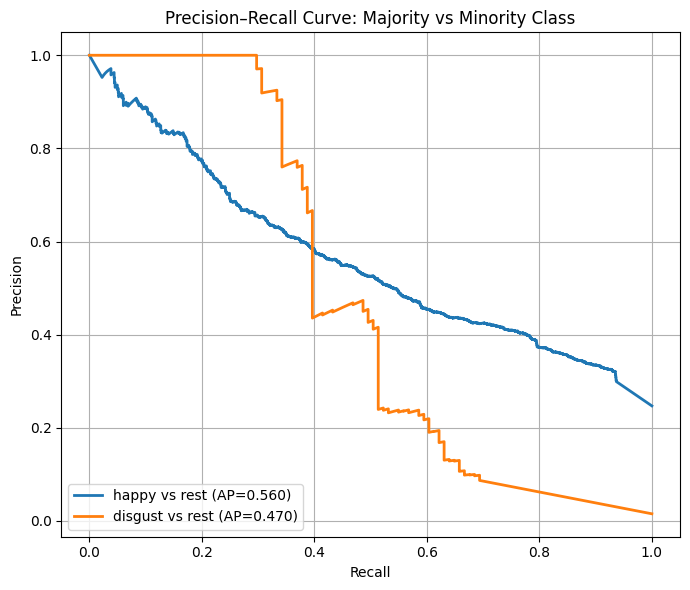

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure classes are consistent with predict_proba ordering
classes = sorted(list(set(y_test)))
class_to_idx = {c: i for i, c in enumerate(classes)}

major_class = "happy"
minor_class = "disgust"

major_idx = class_to_idx[major_class]
minor_idx = class_to_idx[minor_class]

# ------------------------------
# Build ONE-vs-REST binary labels
# ------------------------------
y_true_major = np.array([1 if y == major_class else 0 for y in y_test])
y_true_minor = np.array([1 if y == minor_class else 0 for y in y_test])

y_score_major = y_pred_proba[:, major_idx]
y_score_minor = y_pred_proba[:, minor_idx]

# ------------------------------
# Precision–Recall Curve + Average Precision
# ------------------------------
prec_major, rec_major, _ = precision_recall_curve(y_true_major, y_score_major)
ap_major = average_precision_score(y_true_major, y_score_major)

prec_minor, rec_minor, _ = precision_recall_curve(y_true_minor, y_score_minor)
ap_minor = average_precision_score(y_true_minor, y_score_minor)

# ------------------------------
# Plot
# ------------------------------
plt.figure(figsize=(7, 6))

plt.plot(rec_major, prec_major, label=f"{major_class} vs rest (AP={ap_major:.3f})", lw=2)
plt.plot(rec_minor, prec_minor, label=f"{minor_class} vs rest (AP={ap_minor:.3f})", lw=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve: Majority vs Minority Class")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()
